In [2]:
import numpy as np
import pandas as pd
import h5py
import gc

import sklearn as sk

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import GeneratorEnqueuer

import os
base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)

from Classes.Modeling.LocalOptimizer import LocalOptimizer
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.RamLoader import RamLoader
from Classes.DataProcessing.ts_RamGenerator import data_generator


import sys

import time
import datetime


import random
import pprint
import re
import json

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


# Best Noise-not-noise CNN model evaluation

In [3]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : True,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
helper = HelperFunctions()

2 3
{'noise': 105999, 'earthquake': 105999, 'explosion': 102808}
Mapping redundancy: [--------------------------------------->] 100 %



In [4]:
model_nr_type = "CNN"
num_classes = len(set(loadData.label_dict.values()))
num_channels = 3

optimizer = 'sgd'
num_layers = 1
learning_rate = 0.1
epochs = 50
batch_size = 64
use_layerwise_dropout_batchnorm = True
start_neurons = 290
padding = 'same'
output_layer_activation = 'sigmoid'
l2_r = 0.1
l1_r = 0.0001
kernel_size = 52
filters = 74
dropout_rate = 0.0001
decay_sequence = [1]
activation = 'relu'

timesteps = 6000

optimizer = helper.get_optimizer(optimizer, learning_rate)

model_args = helper.generate_build_model_args(model_nr_type, batch_size, dropout_rate, 
                                                               activation, output_layer_activation,
                                                               l2_r, l1_r, start_neurons, filters, kernel_size, 
                                                               padding, 
                                                               num_layers = num_layers, 
                                                               is_lstm = True, 
                                                               num_classes = num_classes,
                                                               decay_sequence = decay_sequence, 
                                                               channels = num_channels, 
                                                               timesteps = timesteps,
                                                               use_layerwise_dropout_batchnorm = use_layerwise_dropout_batchnorm,
                                                               )
model = DynamicModels(**model_args).model


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6000, 74)          11618     
_________________________________________________________________
dropout (Dropout)            (None, 6000, 74)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6000, 74)          296       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3000, 74)          0         
_________________________________________________________________
activation (Activation)      (None, 3000, 74)          0         
_________________________________________________________________
flatten (Flatten)            (None, 222000)            0     

In [5]:
use_time_augmentor = True
use_noise_augmentor = True
scaler_name = "standard"
filter_name = None
band_min = 2
band_max = 4
highpass_freq = 5

use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = True


ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = False)
x_train, y_train, x_val, y_val, timeAug, scaler, noiseAug = ramLoader.load_to_ram()


Fit process completed after 4.8936052322387695 seconds. Total datapoints fitted: 10520.
Average time per datapoint: 0.00046517160002269674




Stage one loading training set, timeAug: [--------------------------------------->] 100 %



Stage one loading validation set, timeAug: [--------------------------------------->] 100 %



Fitting scaler progress: [------------------->] 100 %



Stage two loading training set, labels and standard scaler: [--------------------------------------->] 100 %



Stage two loading validation set, labels and standard scaler: [--------------------------------------->] 100 %



Completed loading to RAM


In [15]:
train_enq = GeneratorEnqueuer(data_generator(x_train, y_train, batch_size, loadData, handler, noiseAug, num_channels = num_channels, is_lstm  = True), use_multiprocessing = False)
val_enq = GeneratorEnqueuer(data_generator(x_val, y_val,batch_size, loadData, handler, noiseAug, num_channels = num_channels, is_lstm  = True), use_multiprocessing = False)
train_enq.start(workers = 12, max_queue_size = 15)
val_enq.start(workers = 12, max_queue_size = 15)
train_gen = train_enq.get()
val_gen = train_enq.get()

In [18]:
# Generate compiler args using picks
model_compile_args = helper.generate_model_compile_args(optimizer, num_classes)
# Compile model using generated args
model.compile(**model_compile_args)

In [23]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = True

fit_args = helper.generate_fit_args(train_ds, val_ds, batch_size, 
                                         epochs, val_gen, use_tensorboard = use_tensorboard, 
                                         use_liveplots = use_liveplots, 
                                         use_custom_callback = use_custom_callback,
                                         use_early_stopping = use_early_stopping,
                                         use_reduced_lr = use_reduced_lr)

#model.fit(train_gen, **fit_args)

Epoch 1/50
616/616 [==============================] - 23s 32ms/step - loss: 4.9358 - binary_accuracy: 0.7165 - precision: 0.8274 - recall: 0.5379 - val_loss: 0.5003 - val_binary_accuracy: 0.7881 - val_precision: 0.9862 - val_recall: 0.5825
Epoch 2/50
616/616 [==============================] - 19s 31ms/step - loss: 0.4314 - binary_accuracy: 0.8609 - precision: 0.9153 - recall: 0.7904 - val_loss: 0.3305 - val_binary_accuracy: 0.8963 - val_precision: 0.9541 - val_recall: 0.8275
Epoch 3/50
616/616 [==============================] - 20s 32ms/step - loss: 0.3480 - binary_accuracy: 0.8748 - precision: 0.9079 - recall: 0.8317 - val_loss: 0.3424 - val_binary_accuracy: 0.8902 - val_precision: 0.9734 - val_recall: 0.7978
Epoch 4/50
616/616 [==============================] - 19s 31ms/step - loss: 0.5191 - binary_accuracy: 0.8905 - precision: 0.9162 - recall: 0.8590 - val_loss: 0.2868 - val_binary_accuracy: 0.8980 - val_precision: 0.9666 - val_recall: 0.8244
Epoch 5/50
616/616 [====================

In [6]:
save_dir = '/media/tord/T7/Thesis_ssd/SavedModels/CNN'
model_name = 'best_noise-not-noise-model'
model_path = f'{save_dir}/{model_name}'

#model.save(model_path)
model = tf.keras.models.load_model(model_path)


In [13]:
re_x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[2], x_val.shape[1]))
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import sklearn

def predict_model(model, x_test, y_test, class_dict):
    num_predictions = len(y_test)
    #true_labels_str = np.empty(())
    predictions = model.predict(x_test)
    predictions =convert_to_class(predictions)
    predictions = predictions[:num_predictions]
    return predictions


def convert_to_class(predictions):
    if predictions.shape[1] == 1:
        predictions = np.rint(predictions)
        return predictions
    raise Exception("More than two classes has not been implemented")


def evaluate_model(model, x_test, y_test, label_dict, plot = True, run_evaluate = False):
    print(x_test.shape)
    x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[2], x_test.shape[1]))
    print(x_test.shape)
    if run_evaluate:
        loss, accuracy, precision, recall = model.evaluate(x = x_test, y = y_test)

    predictions =predict_model(model, x_test, y_test, label_dict)
    print(predictions.shape)
    predictions = np.reshape(predictions, (predictions.shape[0]))
    print(predictions.shape, y_test.shape)
    y_test = np.reshape(y_test, (y_test.shape[0]))
    print(y_test.shape)
    conf = tf.math.confusion_matrix(y_test, predictions, num_classes=2)
    class_report = classification_report(y_test, predictions, target_names =handle_non_noise_dict(label_dict))
    if plot:
        plot_confusion_matrix(conf, label_dict)
    print(conf)
    print(class_report)


    return conf, class_report

def plot_confusion_matrix(conf, label_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf)
    labels = list(handle_non_noise_dict(label_dict))
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    print(conf.shape)
    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            text = ax.text(j, i, int(conf[i, j]), ha="center", va="center", color="r")

    plt.show()


def handle_non_noise_dict(label_dict):
    if len(list(set(label_dict.values()))) == 2 and len(list(label_dict.keys())) == 3:
        label_dict = {'noise' : 0, 'not_noise' : 1}
    return label_dict


(1578, 3, 6000)
(1578, 6000, 3)
50/50 [==============================] - 1s 4ms/step - loss: 0.2479 - binary_accuracy: 0.9335 - precision: 0.9314 - recall: 0.9373
(1578, 1)
(1578,) (1578, 1)
(1578,)
(2, 2)


<ipython-input-13-4eff84a2b08b>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-13-4eff84a2b08b>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


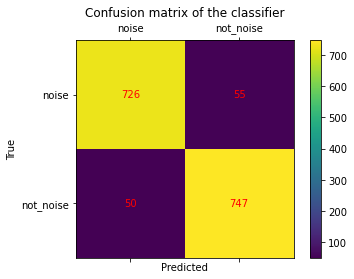

tf.Tensor(
[[726  55]
 [ 50 747]], shape=(2, 2), dtype=int32)
              precision    recall  f1-score   support

       noise       0.94      0.93      0.93       781
   not_noise       0.93      0.94      0.93       797

    accuracy                           0.93      1578
   macro avg       0.93      0.93      0.93      1578
weighted avg       0.93      0.93      0.93      1578



In [15]:
conf, report = evaluate_model(model, x_val, y_val, loadData.label_dict, run_evaluate = True)

In [123]:
print(conf)

tf.Tensor(
[[3779  203]
 [ 279 3629]], shape=(2, 2), dtype=int32)


In [81]:
print(report)

              precision    recall  f1-score   support

       noise       0.93      0.95      0.94      3982
   not_noise       0.95      0.93      0.94      3908

    accuracy                           0.94      7890
   macro avg       0.94      0.94      0.94      7890
weighted avg       0.94      0.94      0.94      7890

